# CD4+ T cell behavior in COVID-19 infection


In [1]:
# Load library and BoolNetPerturb functions
library(dplyr)
library(BoolNet)
library(alluvial)
for (f in list.files("BNP")) source( paste('BNP/', f, sep='') )
# Load data
net <-  loadNetwork("data/thsocs_net.csv")
net.covmod <- loadNetwork("data/thsocs_net_covmod.csv")
net.covsev <- loadNetwork("data/thsocs_net_covsev.csv")
net.covtgfb <- loadNetwork("data/thsocs_net_covtgfb.csv")

lab <- read.csv("data/thsocs_label.csv")
env <- read.csv("data/thsocs_environment.csv")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## CD4+ T cell regulatory network and subsets
    * [/] Th network
    * [/] Th subsets color:red/yellow
    * [/] Th subsets table

### Regulatory network
![CD4+ T cell regulatory network](images/thsocs_net.png)

### Attractors

null device 
          1

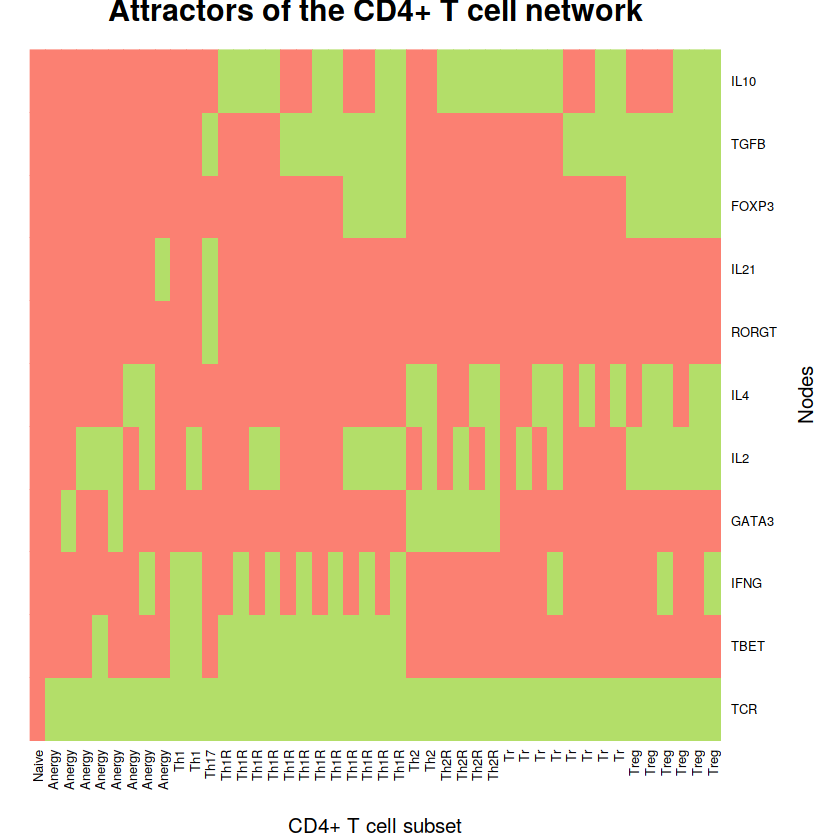

In [2]:
file.attr <- "data/thsocs_attr_WT.csv"
file.attr.pdf <- "images/thsocs_attr.pdf"

if (! file.exists(file.attr)) {
    # calculate attractors
    attr <- getAttractors(net)
    labels <- labelAttractors(attr, lab, net_$genes)
    # add subset labels
    attr.table <- attractorToDataframe(attr, Boolean=TRUE)
    attr.table$attractor <- labels
    attr.table <- attr.table[with(attr.table, order(
                             TCR, attractor, FOXP3, TGFB, IL10, 
                             IL21,RORGT,IL4,IL2,GATA3,IFNG,TBET)),]
    write.csv(attr.table,file.attr, row.names=FALSE)
} else {
    attr.table <- read.csv(file = file.attr)
}

# select key nodes for plotting
attr.table <- subset(attr.table, select = c("attractor","TCR", 
                                            "TBET","IFNG","GATA3","IL2","IL4",
                                            "RORGT","IL21","FOXP3","TGFB","IL10") )
attr.table <- unique(attr.table)

if (! file.exists(file.attr.pdf)) { pdf(file.attr.pdf) }
heatmap(t(as.matrix( subset(attr.table, select=-attractor ))),
        labCol=attr.table$attractor,
        main="Attractors of the CD4+ T cell network", 
        xlab="CD4+ T cell subset", ylab="Nodes",
        col=c('#fb8072','#b3de69'), cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
dev.off()

## Effect of the environment in CD4+ T cell differentiation during COVID-19
    * [/] Cytokines
    * [/] Celltype by env table
    * [/] Celltype by env color:brown
    
### Environments

In [3]:
# plot environments
env

,IFNGe,IL12e,IL2e,IL4e,IL6e,TGFBe,IL10e
Basal,0,0,0,0,0,0,0
pro-Th1,1,1,0,0,0,0,0
pro-Th2,0,0,1,1,0,0,0
pro-Th17,0,0,0,0,1,1,0
pro-Treg,0,0,1,0,0,1,0
Pro-Tr,0,0,0,0,0,1,1
CoV-mod,1,1,0,0,0,0,0
CoV-sev,1,1,0,1,1,0,0
CoV-sev-TGFB,1,1,0,1,1,1,0


### Basin size by environment

* CoV-mod has the same signature as Th1
* CoV-mod and CoV-sev have similar presence of celltypes:
    * Anergy, Th1, Th1R, Th2R, Tr
* In CoV-sev the anergy basin is 4 times biger, while the Th1 basin is half, with little change in regulatory cell types
* If there is TGFB in CoV-sev we have Th17, Th1R and Tr with no Treg or Th1
    * possible worst outcome, activation of innate inflamation, no adaptive citotoxicity, also fibrosis
    * check TGFB in patients, while it may have regulatory effects it may induce Th17

In [4]:
file.env.attr <- "data/thsocs_env_attr.csv"
file.env.attr.pdf <- "images/thsocs_env_attr.pdf"

if (! file.exists(file.env.attr)) {
    env.attr <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                              genes  = rep( list(colnames(env)), times=nrow(env) ),
                              values = lapply( split(env,seq_along(env[,1])), as.list),
                              names  = rownames(env))
    env.attr[env.attr == 0] <- NA
    write.csv(env.attr,file.env.attr)
} else {
    env.attr <- read.csv(file = file.env.attr, row.names=1)
}
env.attr

,Basal,pro.Th1,pro.Th2,pro.Th17,pro.Treg,Pro.Tr,CoV.mod,CoV.sev,CoV.sev.TGFB
Anergy,8670,1232,804,NA,NA,NA,1232,5264,NA
Naive,16384,16384,16384,16384,16384,16384,16384,16384,16384
Th1,940,6280,272,NA,NA,NA,6280,3936,NA
Th17,NA,NA,NA,8704,156,NA,NA,NA,3456
Th1R,2088,7992,264,1088,2672,2672,7992,6352,10288
Th2,454,NA,8988,NA,NA,NA,NA,NA,NA
Th2R,112,88,112,NA,NA,NA,88,80,NA
Tr,4120,792,1192,6592,2110,13712,792,752,2640
Treg,NA,NA,4752,NA,11446,NA,NA,NA,NA


null device 
          1

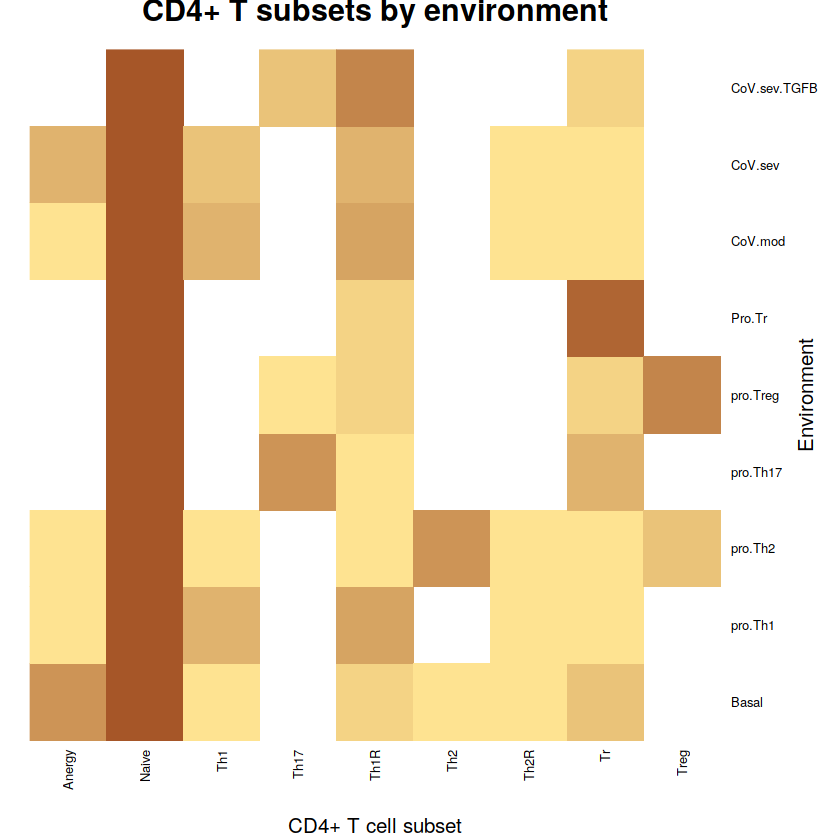

In [5]:
presence = F

if (presence) {
    env.attr <- env.attr/env.attr
    color = '#a65628'
} else { 
    colfunc <- colorRampPalette(c('#fee391', '#a65628'))
    color <- colfunc(10)
}

if (! file.exists(file.env.attr.pdf)) { pdf(file.env.attr.pdf) }
heatmap(t(as.matrix( subset(env.attr ))),
        main="CD4+ T subsets by environment", 
        xlab="CD4+ T cell subset", ylab="Environment",
        col=color, cexCol=0.75, cexRow=0.75,
        Colv = NA, Rowv = NA, scale="none",
       )
dev.off()

## CD4+ T cell stability and plasticity in COVID-19
    * [/] Cell fate map table covmod and covsev 
    * [/] transitions by node color:red/yellow
    * [/] Stability by subset in covmod and covsev

In [6]:
f.cfm.table <- function(net, lab, file.name) {
    if (! file.exists(file.name)) {
        cfm <- cellFateMap(net, label.rules=lab, 
                           method="sat.restricted", maxAttractorLength=2) 
        cfm <- apply(cfm,2,as.character)
        cfm <- cfm[  order( cfm[,1], cfm[,2], cfm[,3], cfm[,4] ),]
        write.csv(cfm,file.name, row.names=F)
    } else {
        cfm <- read.csv(file = file.name)
    }
    cfm
}
cfm.covmod <- f.cfm.table(net.covmod, lab, "data/thsocs_cfm_covmod.csv")
cfm.covsev <- f.cfm.table(net.covsev, lab, "data/thsocs_cfm_covsev.csv")
cfm.covtgfb <- f.cfm.table(net.covtgfb, lab, "data/thsocs_cfm_covtgfb.csv")

### Transitions by node

In [ ]:
plot.node.transitions <- function(cfm, file.name, normalize=T, title='') {
    cfm.diff <- cfm[cfm$initial!=cfm$final,]
    node.transitions <- merge( summary(cfm.diff[cfm.diff$values==0,'genes']), 
                               summary(cfm.diff[cfm.diff$values==1,'genes']),
                               by=0, all=TRUE)
    rownames(node.transitions) <- node.transitions$Row.names
    node.transitions <- subset(node.transitions, select = -Row.names )
    colnames(node.transitions) <- c('activation','inhibition')
    node.transitions <- node.transitions[net$genes,]
    if (normalize) { node.transitions <- node.transitions/summary(cfm$genes) }
    node.transitions
    
    if (! file.exists(file.name)) { 
        pdf(file.name) 
        save.pdf <- T
    }
    barplot(t(as.matrix( node.transitions )),
            main=title, xlab='nodes', ylab='% of transitions caused when perturbed',
            col=c('#b3de69','#fb8072'), ylim=c(0,1), las=2, legend=T,
           )
    if (save.pdf) { dev.off() }
}

plot.node.transitions(cfm.covmod, 'images/thsocs_transitionnode_covmod.pdf', 
                      title='Transitions among subsets by node in CoV-mod')
plot.node.transitions(cfm.covsev, 'images/thsocs_transitionnode_covsev.pdf',
                      title='Transitions among subsets by node in CoV-sev')
plot.node.transitions(cfm.covtgfb, 'images/thsocs_transitionnode_covtgfb.pdf',
                      title='Transitions among subsets by node in CoV-sev-TGFB')

### Stability by celltype

[1] "Transitions between cell types in CoV-mod"
[1] "Transitions between cell types in CoV-sev"


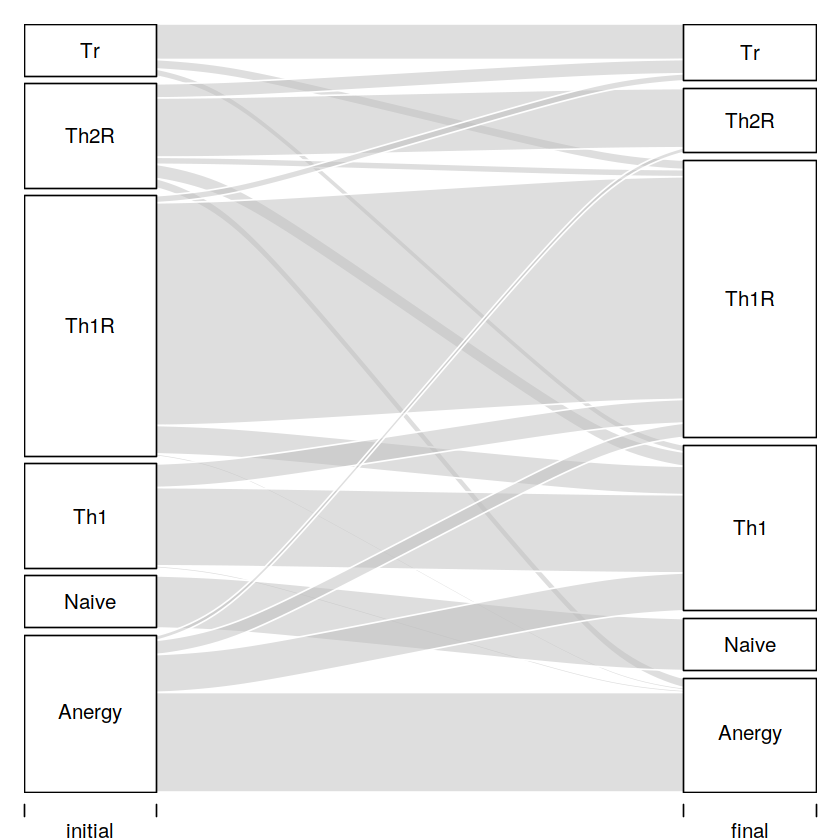

[1] "Transitions between cell types in CoV-sev-TGFB"


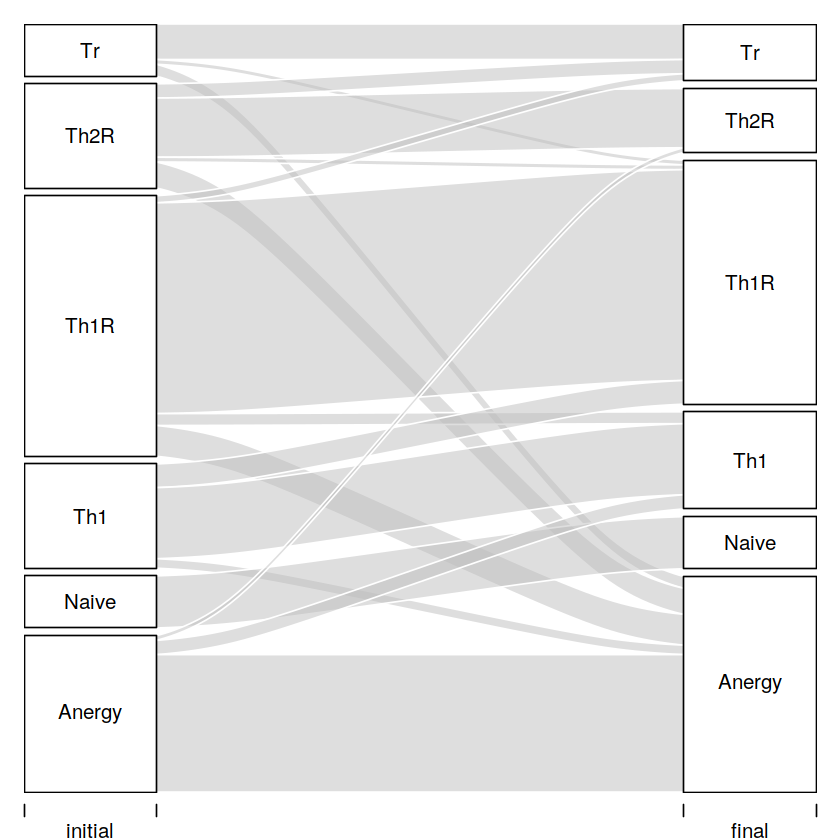

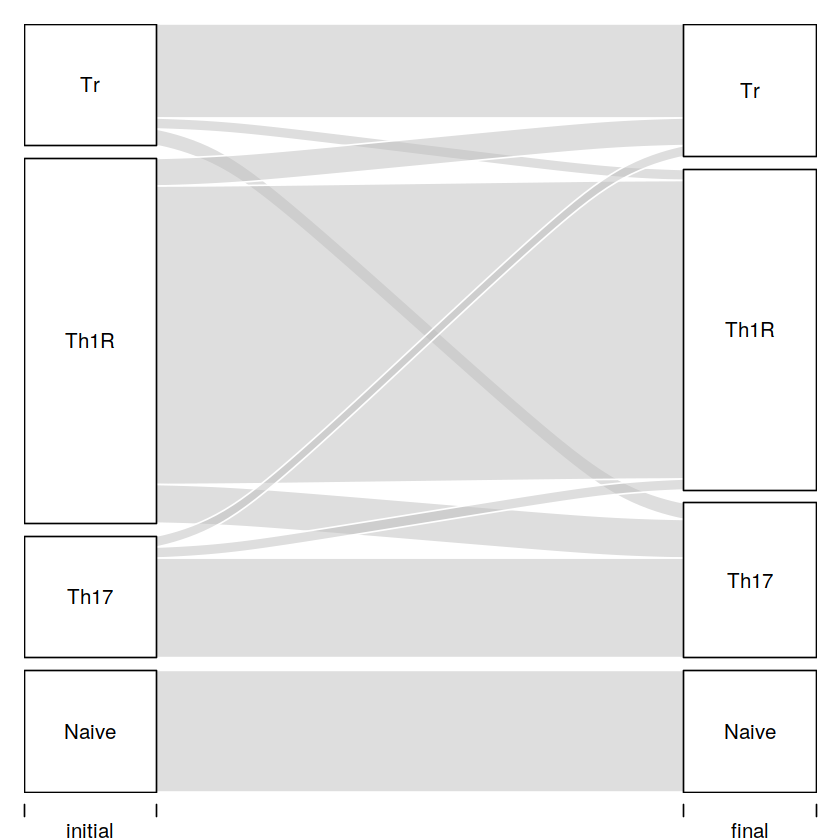

In [9]:
plot.cfm.alluvial <- function(cfm, file.name, title='') {
    if (! file.exists(file.name)) { pdf(file.name) }
    cfm %>% group_by(initial, final) %>%
            summarize(freq = n()) -> cfm2d
    print(title)
    alluvial(cfm2d[,1:2], freq=cfm2d$freq)
    if (! file.exists(file.name)) { dev.off() }
    }

plot.cfm.alluvial(cfm.covmod, 'images/thsocs_alluvial_covmod.pdf',
                  title='Transitions between cell types in CoV-mod')
plot.cfm.alluvial(cfm.covsev, 'images/thsocs_alluvial_covsev.pdf',
                  title='Transitions between cell types in CoV-sev')
plot.cfm.alluvial(cfm.covtgfb, 'images/thsocs_alluvial_covtgfb.pdf',
                  title='Transitions between cell types in CoV-sev-TGFB')

## CD4+ T cell KO and overexpression mutants in COVID-19
    * [/] Mutants in WT, covmod, and covsev table
    * [/] Mutants in WT, covmod, and covsev scale:purple
    * [/] Compare covmod vs covsev

In [10]:
f.mut.table <- function(net, lab, file.name) {
    if (! file.exists(file.name)) {
        mutants <- perturbNetworkFixedNodes(net, label.rules=lab)
        mut_socs <- perturbNetworkFixedNodes(net, label.rules=lab, returnDataFrame='basinSize',
                                         genes  = list(c('SOCS1','SOCS2','SOCS3','SOCS5'),c('SOCS1','SOCS2','SOCS3','SOCS5')),
                                         values = list(0,1),
                                         names  = c('SOCSall_0','SOCSall_1'))
        mutants <- merge(mutants, mut_socs, by=0, all=TRUE)
        rownames(mutants) <- mutants$Row.names
        mutants <- subset(mutants, select = -c(Row.names) )
        mutants[mutants == 0] <- NA
        write.csv(mutants,file.name)
    } else {
        mutants <- read.csv(file = file.name, row.names=1)
    }
    mutants
}

f.mut.plot <- function(mutants, file.name, save.pdf=FALSE) {
    if (save.pdf) { pdf(image.name) }
    mutants <- mutants/mutants
    heatmap(t(as.matrix( mutants )),
            main="CD4+ T subsets mutants", 
            xlab="CD4+ T cell subset", ylab="Mutant",
            col=c('#bebada'), cexCol=0.75, cexRow=0.75,
            Colv = NA, Rowv = NA, scale="none",
           )
    if (save.pdf) {dev.off() }
}

In [ ]:
f.mut <- f.mut.table(net, lab, "data/thsocs_mut_wt.csv")
f.mut.plot(f.mut, "images/thsocs_mut_wt.pdf")

In [ ]:
net.covmod <- loadNetwork("data/thsocs_net_covmod.csv")
f.mut.covmod <- f.mut.table(net.covmod, lab, "data/thsocs_mut_covmod.csv")
f.mut.plot(f.mut.covmod, "images/thsocs_mut_covmod.pdf")

In [ ]:
net.covsev <- loadNetwork("data/thsocs_net_covsev.csv")
f.mut.covsev <- f.mut.table(net.covsev, lab, "data/thsocs_mut_covsev.csv")
f.mut.plot(f.mut.covsev, "images/thsocs_mut_covsev.pdf")

In [ ]:
net.covtgfb <- loadNetwork("data/thsocs_net_covtgfb.csv")
f.mut.covtgfb <- f.mut.table(net.covtgfb, lab, "data/thsocs_mut_covtgfb.csv")
f.mut.plot(f.mut.covtgfb, "images/thsocs_mut_covtgfb.pdf")

In [ ]:
rowSums(f.mut.covsev>f.mut.covmod, na.rm=T)